<a href="https://colab.research.google.com/github/vlad-danaila/ml-cancer-detection/blob/master/Cancer_Detection_Ensable_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Download dependencies**

In [0]:
!pip3 install torch==1.3.1+cu92 torchvision==0.4.2+cu92 -f https://download.pytorch.org/whl/torch_stable.html 

In [0]:
!pip3 install sklearn matplotlib GPUtil pytorch-gradcam

  Created wheel for GPUtil: filename=GPUtil-1.4.0-cp36-none-any.whl size=7410 sha256=d7db8000ed856719c3769c7dac7d708707a181c610cbd746ec28415d125223a5
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built GPUtil


**Download data**

Mount my google drive, where I stored the dataset. 

In order to acquire the dataset please navigate to:

https://ieee-dataport.org/documents/cervigram-image-dataset

In [0]:
try:
    from google.colab import drive
    drive.mount('/content/drive')
except Exception as e:
    print(e)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Unzip the dataset into the folder "dataset". For your environment, please adjust the paths accordingly.

In [0]:
!rm -vrf "dataset"
!mkdir "dataset"
!cp -r "/content/drive/My Drive/Studiu doctorat leziuni cervicale/cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
# !cp -r "cervigram-image-dataset-v2.zip" "dataset/cervigram-image-dataset-v2.zip"
!unzip "dataset/cervigram-image-dataset-v2.zip" -d "dataset"

Archive:  dataset/cervigram-image-dataset-v2.zip
   creating: dataset/data/
   creating: dataset/data/test/
   creating: dataset/data/test/0/
   creating: dataset/data/test/0/20151103002/
  inflating: dataset/data/test/0/20151103002/20151103113458.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113637.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113659.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113722.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113752.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113755.jpg  
  inflating: dataset/data/test/0/20151103002/20151103113833.jpg  
   creating: dataset/data/test/0/20151103005/
  inflating: dataset/data/test/0/20151103005/20151103161719.jpg  
  inflating: dataset/data/test/0/20151103005/20151103161836.jpg  
  inflating: dataset/data/test/0/20151103005/20151103161908.jpg  
  inflating: dataset/data/test/0/20151103005/20151103161938.jpg  
  inflating: dataset/data/test/0/2015110

**Constants**

For your environment, please modify the paths accordingly.  

In [0]:
TRAIN_PATH = '/content/dataset/data/train/'
TEST_PATH = '/content/dataset/data/test/'
# TRAIN_PATH = 'dataset/data/train/'
# TEST_PATH = 'dataset/data/test/'

CROP_SIZE = 260
IMAGE_SIZE = 224
BATCH_SIZE = 100

prefix = '/content/drive/My Drive/Studiu doctorat leziuni cervicale/V2/Chekpoints & Notebooks/'
CHECKPOINT_NATURAL_IMG_MODEL = prefix + 'Cancer Detection MobileNetV2 All Natural Images Full Conv32-0.7 6 Dec.tar'
CHECKPOINT_GREEN_LENS_IMG_MODEL = prefix + 'Cancer_Detection_MobileNetV2_Green_Lens_2_Dec Full Conv 64 0.7.tar'
CHECKPOINT_IODINE_SOLUTION_IMG_MODEL = prefix + 'Cancer_Detection_MobileNetV2_Iodine_1_Dec Full Conv32.tar'
CHECKPOINT_ENSAMBLE = prefix + 'Cancer Detection - Ensable Conv 7 Dec.tar'

**Imports**

In [0]:
import torch as t
import torchvision as tv
import numpy as np
import PIL as pil
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
from torch.nn import Linear, BCEWithLogitsLoss
import sklearn as sk
import sklearn.metrics
from os import listdir
import time
import random
import PIL
from torchvision.utils import make_grid, save_image
import os
from gradcam.utils import visualize_cam, Normalize

**Deterministic measurements**

This statements help making the experiments reproducible by fixing the random seeds. Despite fixing the random seeds, experiments are usually not reproducible using different PyTorch releases, commits, platforms or between CPU and GPU executions. Please find more details in the PyTorch documentation:

https://pytorch.org/docs/stable/notes/randomness.html

In [0]:
SEED = 0
t.manual_seed(SEED)
t.cuda.manual_seed(SEED)
t.cuda.manual_seed_all(SEED)
t.backends.cudnn.deterministic = True
t.backends.cudnn.benchmark = False
np.random.seed(SEED)
random.seed(SEED)

**Memory stats**

In [0]:
import GPUtil
def memory_stats():
  for gpu in GPUtil.getGPUs():
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
memory_stats()

GPU RAM Free: 16280MB | Used: 0MB | Util   0% | Total 16280MB


**Loading data**

The dataset is structured in multiple small folders of 7 images each. This generator iterates through the folders and returns the category and 7 paths: one for each image in the folder. The paths are ordered; the order is important since each folder contains 3 types of images, first 5 are with acetic acid solution and the last two are through a green lens and having iodine solution(a solution of a dark red color).

In [0]:
def sortByLastDigits(elem):
  chars = [c for c in elem if c.isdigit()]
  return 0 if len(chars) == 0 else int(''.join(chars))

def getImagesPaths(root_path):
  for  class_folder in [root_path + f for f in listdir(root_path)]:
      category = int(class_folder[-1])
      for case_folder in listdir(class_folder):
        case_folder_path = class_folder + '/' + case_folder + '/'
        img_files = [case_folder_path + file_name for file_name in listdir(case_folder_path)]
        yield category, sorted(img_files, key = sortByLastDigits)

We define datasets which load 3 kinds of images: natural images, images taken through a green lens and images where the doctor applied iodine solution (which gives a dark red color). Each dataset has dynamic and static transformations which could be applied to the data. The static transformations are applied on the initialization of the dataset, while the dynamic ones are applied when loading each batch of data. 

In [0]:
class SimpleImagesDataset(t.utils.data.Dataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
      for i in range(5):
        img = pil.Image.open(img_files[i])
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    
  
  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.transforms_x != None:
      x = self.transforms_x(x)
    if self.transforms_y != None:
      y = self.transforms_y(y)
    return x, y

  def __len__(self):
    return len(self.dataset)

class GreenLensImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-2]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

class RedImagesDataset(SimpleImagesDataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None):
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
        # Only the green lens image
        img = pil.Image.open(img_files[-1]) 
        if transforms_x_static != None:
          img = transforms_x_static(img)
        if transforms_y_static != None:
          category = transforms_y_static(category)
        self.dataset.append((img, category))    

class TransformsRand:
  def __init__(self):
    self.angle = random.random()
    self.scale = random.random()
    self.shear = random.random()
    self.hflip = random.random()
        
class AllImagesDataset(t.utils.data.Dataset):
  def __init__(self, root_path, transforms_x_static = None, transforms_x_dynamic = None, transforms_y_static = None, transforms_y_dynamic = None, is_train = True):
    self.is_train = is_train
    self.dataset = []
    self.transforms_x = transforms_x_dynamic
    self.transforms_y = transforms_y_dynamic
    for category, img_files in getImagesPaths(root_path):
      imgs = []
      for i in range(7):
        img = pil.Image.open(img_files[i])
        if transforms_x_static != None:
          img = transforms_x_static(img)
        imgs.append(img)
      if transforms_y_static != None:
        category = transforms_y_static(category)
      self.dataset.append((imgs, category))    
  
  def __getitem__(self, i):
    x, y = self.dataset[i]
    if self.transforms_x != None:
      if self.is_train:
        rand = TransformsRand()
        x = [self.transforms_x(_x, rand = rand) for _x in x]
#         x = [self.transforms_x(_x) for _x in x]
      else:
        x = [self.transforms_x(_x) for _x in x]
    if self.transforms_y != None:
      y = self.transforms_y(y)
    return x, y

  def __len__(self):
    return len(self.dataset)

**Preprocess data**

Convert PyTorch tensor to Numpy array.

In [0]:
def to_numpy(x):
  return x.cpu().detach().numpy()

Data transformations for the test and training sets.

In [0]:
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

def custom_transforms(x, angle = 45, scale = (1., 2.), shear = 30, rand = None):
    if rand == None:
        rand = TransformsRand()
    angle = angle * rand.angle
    scale_value = scale[0] + ((scale[1] - scale[0]) * rand.scale)
    shear = shear * rand.shear
    x = tv.transforms.functional.affine(x, angle = angle, scale = scale_value, shear = shear, translate = [0, 0])
    x = tv.transforms.functional.resize(x, IMAGE_SIZE)
    if rand.hflip > .5:
        x = tv.transforms.functional.hflip(x)
    x = tv.transforms.functional.to_tensor(x).cuda()
    x = tv.transforms.functional.normalize(x, mean=norm_mean, std=norm_std)
    return x

transforms_train = tv.transforms.Compose([
    tv.transforms.RandomAffine(degrees  = 45, translate = None, scale = (1., 2.), shear = 30),
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.RandomHorizontalFlip(),
    tv.transforms.ToTensor(),
    tv.transforms.Lambda(lambda t: t.cuda()),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

transforms_test = tv.transforms.Compose([
    # tv.transforms.CenterCrop(CROP_SIZE),
    tv.transforms.Resize(IMAGE_SIZE),
    tv.transforms.ToTensor(),
    tv.transforms.Normalize(mean=norm_mean, std=norm_std)    
])

y_transform = tv.transforms.Lambda(lambda y: t.tensor(y, dtype=t.long, device = 'cuda:0'))

Initialize PyTorch datasets and loaders for training and test.

In [0]:
def create_loaders():
  dataset_train = AllImagesDataset(TRAIN_PATH, transforms_x_dynamic = custom_transforms, transforms_y_dynamic = y_transform)
  dataset_test = AllImagesDataset(TEST_PATH, transforms_x_static = transforms_test, 
        transforms_x_dynamic = tv.transforms.Lambda(lambda t: t.cuda()), transforms_y_dynamic = y_transform, is_train = False)

  loader_train = DataLoader(dataset_train, BATCH_SIZE, shuffle = True, num_workers = 0)
  loader_test = DataLoader(dataset_test, BATCH_SIZE, shuffle = False, num_workers = 0)
  return loader_train, loader_test, len(dataset_train), len(dataset_test)

In [0]:
loader_train_simple_img, loader_test_simple_img, len_train, len_test = create_loaders()

**Visualize data**

Load a few images so that we can see the efects of the data augmentation on the training set.

In [0]:
def plot_one_prediction(x, label, pred):  
  x, label, pred = to_numpy(x), to_numpy(label), to_numpy(pred)
  x = np.transpose(x, [1, 2, 0])
  if x.shape[-1] == 1:
    x = x.squeeze()
  x = x * np.array(norm_std) + np.array(norm_mean)
  plt.title(label, color = 'green' if label == pred else 'red')
  plt.imshow(x)

def plot_one(x, norm = True):  
  x = to_numpy(x)
  x = np.transpose(x, [1, 2, 0])
  if x.shape[-1] == 1:
    x = x.squeeze()
  if norm:
    x = x * np.array(norm_std) + np.array(norm_mean)
  plt.imshow(x)

def plot_predictions(imgs, labels, preds):  
  fig = plt.figure(figsize = (20, 5))
  for i in range(20):
    fig.add_subplot(2, 10, i + 1, xticks = [], yticks = [])
    plot_one_prediction(imgs[i], labels[i], preds[i])

In [0]:
# x, y = next(iter(loader_train_simple_img))
# for i in range(7):
#   plot_predictions(x[i], y, y)

**Model**

Define a few models to experiment with.

In [0]:
def get_mobilenet_v2():
  model = t.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=True)
  model.classifier[0] = t.nn.Dropout(p=0.9, inplace=False)
  model.classifier[1] = Linear(in_features=1280, out_features=4, bias=True)
  model.features[18].add_module('cnn_drop_18', t.nn.Dropout2d(p = .3))
  model.features[17]._modules['conv'][1].add_module('cnn_drop_17', t.nn.Dropout2d(p = .2))
  model.features[16]._modules['conv'][1].add_module('cnn_drop_16', t.nn.Dropout2d(p = .1))
  model = model.cuda()
  return model

def get_vgg_19():
  model = tv.models.vgg19(pretrained = True)
  model = model.cuda()
  model.classifier[2].p = .9
  model.classifier[6].out_features = 4
  return model

def get_res_next_101():
  model = t.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')
  model.fc = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features=2048, out_features=4)
  )
  model = model.cuda()
  return model

def get_resnet_18():
  model = tv.models.resnet18(pretrained = True)
  model.fc = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features=512, out_features=4)
  )
  model = model.cuda()
  return model

def get_dense_net():
  model = tv.models.densenet121(pretrained = True)
  model.classifier = t.nn.Sequential(
      t.nn.Dropout(p = .9),
      t.nn.Linear(in_features = 1024, out_features = 4)
  )
  model = model.cuda()
  return model

Define ensemble

In [0]:
class WrappedModel(t.nn.Module):
	def __init__(self, module):
		super().__init__()
		self.module = module # that I actually define.
	def forward(self, x):
		return self.module(x)

class MobileNetV2_FullConv(t.nn.Module):
  def __init__(self, end_channels):
    super().__init__()
    self.cnn = get_mobilenet_v2().features
    self.cnn[18] = t.nn.Sequential(
      tv.models.mobilenet.ConvBNReLU(320, end_channels, kernel_size=1)
    )
    self.fc = t.nn.Linear(end_channels, 4)

  def forward(self, x):
    x = self.cnn(x)
    x = x.mean([2, 3])
    x = self.fc(x);
    return x
    
class Ensamble(t.nn.Module):
  def __init__(self):
    super().__init__()
    self.model_simple = MobileNetV2_FullConv(32).cnn
    self.model_green = MobileNetV2_FullConv(64).cnn
    self.model_red = MobileNetV2_FullConv(32).cnn
    channels = 32 * 5 + 64 + 32
    fc_size = 32
    self.classifier = tv.models.mobilenet.InvertedResidual(inp = channels, oup = fc_size, stride = 1, expand_ratio = 5)
    self.classifier._modules['conv'][0].add_module('classifier_drop_1', t.nn.Dropout2d(p = .2))
    self.classifier._modules['conv'][1].add_module('classifier_drop_1', t.nn.Dropout2d(p = .2))
    self.fc = t.nn.Sequential(
        # t.nn.Dropout(p = .2),
        t.nn.Linear(fc_size, 4)
    )

  def forward(self, x):
    x_list = []
    for i in range(5):
      x_list.append(self.model_simple(x[i]))
    x_list.append(self.model_green(x[5]))
    x_list.append(self.model_red(x[6]))
    x_concat = t.cat(x_list, 1)
    x_concat = self.classifier(x_concat)
    x_concat = x_concat.mean([2, 3])
    x_concat = self.fc(x_concat)
    return x_concat

def cnn(checkpoint_path):
  cnn = t.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=False)
  cnn.classifier[0] = t.nn.Dropout(p=0, inplace=False)
  cnn.classifier[1] = Linear(in_features=1280, out_features=4, bias=True)
  checkpoint = t.load(checkpoint_path)
  cnn.load_state_dict(checkpoint['model'])
  for param in cnn.parameters():
    param.requires_grad = False
  return cnn

def cnn_from_data_parallel(checkpoint_path):
  cnn = t.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=False)
  cnn.classifier[0] = t.nn.Dropout(p=0, inplace=False)
  cnn.classifier[1] = Linear(in_features=1280, out_features=4, bias=True)
  cnn = WrappedModel(cnn)
  checkpoint = t.load(checkpoint_path)
  cnn.load_state_dict(checkpoint['model'])
  for param in cnn.parameters():
    param.requires_grad = False
  return cnn

def cnn_full_conv(checkpoint_path, end_channels_nb):  
  cnn = MobileNetV2_FullConv(end_channels_nb)
  checkpoint = t.load(checkpoint_path)
  cnn.load_state_dict(checkpoint['model'])
  for param in cnn.parameters():
    param.requires_grad = False
  return cnn

def cnn_full_conv_new(end_channels_nb):  
  cnn = MobileNetV2_FullConv(end_channels_nb)
  checkpoint = t.load(checkpoint_path)
  cnn.load_state_dict(checkpoint['model'])
  for param in cnn.parameters():
    param.requires_grad = False
  return cnn

**Grad CAM ++ Analysis**

**All code below is an adaptation of the sourcecode of pytorch-gradcam (MIT license).**

**The original can be found at:** https://pypi.org/project/pytorch-gradcam/

In [0]:
def get_images(index):
  x, y = next(iter(loader_test_simple_img))
  normed_torch_imgs = []
  for i in range(7):
    normed_torch_img = x[i][index].unsqueeze_(0)
    normed_torch_imgs.append(normed_torch_img)
  return normed_torch_imgs, y[index].item()

In [0]:
def compute_mask(gradients, activations, score):
  b, k, u, v = gradients.size()

  alpha_num = gradients.pow(2)
  alpha_denom = gradients.pow(2).mul(2) + \
    activations.mul(gradients.pow(3)).view(b, k, u*v).sum(-1, keepdim=True).view(b, k, 1, 1)
  alpha_denom = t.where(alpha_denom != 0.0, alpha_denom, t.ones_like(alpha_denom))

  alpha = alpha_num.div(alpha_denom+1e-7)
  positive_gradients = t.nn.functional.relu(score.exp()*gradients) # ReLU(dY/dA) == ReLU(exp(S)*dS/dA))
  weights = (alpha*positive_gradients).view(b, k, u*v).sum(-1).view(b, k, 1, 1)

  saliency_map = (weights*activations).sum(1, keepdim=True)
  saliency_map = t.nn.functional.relu(saliency_map)
  saliency_map = t.nn.functional.upsample(saliency_map, size=(224, 298), mode='bilinear', align_corners=False)
  saliency_map_min, saliency_map_max = saliency_map.min(), saliency_map.max()
  saliency_map = (saliency_map-saliency_map_min).div(saliency_map_max-saliency_map_min).data
  return saliency_map

In [0]:
def extract_gradients_and_compute_mask(normed_torch_imgs):  
  gradients_natural, gradients_green, gradients_iodine = [], [], []
  activations_natural, activations_green, activations_iodine = [], [], []

  def backward_hook_natural(module, grad_input, grad_output):
    gradients_natural.append(grad_output[0])
    return None

  def forward_hook_natural(module, input, output):
    activations_natural.append(output)
    return None

  def backward_hook_green(module, grad_input, grad_output):
    gradients_green.append(grad_output[0])
    return None

  def forward_hook_green(module, input, output):
    activations_green.append(output)
    return None

  def backward_hook_iodine(module, grad_input, grad_output):
    gradients_iodine.append(grad_output[0])
    return None

  def forward_hook_iodine(module, input, output):
    activations_iodine.append(output)
    return None

  model = t.nn.DataParallel(Ensamble().cuda())
  checkpoint = t.load(CHECKPOINT_ENSAMBLE)
  model.load_state_dict(checkpoint['model'])

  model.eval()

  target_layer_simple = model.module.model_simple[-1][0][0]
  target_layer_simple.register_forward_hook(forward_hook_natural)
  target_layer_simple.register_backward_hook(backward_hook_natural)

  target_layer_green = model.module.model_green[-1][0][0]
  target_layer_green.register_forward_hook(forward_hook_green)
  target_layer_green.register_backward_hook(backward_hook_green)

  target_layer_iodine = model.module.model_red[-1][0][0]
  target_layer_iodine.register_forward_hook(forward_hook_iodine)
  target_layer_iodine.register_backward_hook(backward_hook_iodine)

  b, c, h, w = normed_torch_imgs[0].size()

  logit = model.forward(normed_torch_imgs)

  score = logit[:, logit.max(1)[-1]].squeeze()
  # score = logit[:, 2].squeeze()

  model.zero_grad()
  score.backward(retain_graph = False)
  
  masks = [compute_mask(gradients_natural[i], activations_natural[i], score) for i in range(5)]
  masks.append(compute_mask(gradients_green[0], activations_green[0], score))
  masks.append(compute_mask(gradients_iodine[0], activations_iodine[0], score))

  return masks, logit.max(1).indices.item()

In [0]:
def visualize_masked_img(mask, img_original):
  images = []
  mask = t.nn.functional.upsample(mask, size=img_original.shape[1:], mode='bilinear', align_corners=False)
  heatmap, result = visualize_cam(mask.cpu(), img_original.cpu())
  images.append(t.stack([img_original.cpu(), result], 0))
  images = make_grid(t.cat(images, 0), nrow=2)
  output_dir = 'outputs'
  os.makedirs(output_dir, exist_ok=True)
  output_name = 'out.JPEG'
  output_path = os.path.join(output_dir, output_name)
  save_image(images, output_path)
  plt.imshow(PIL.Image.open(output_path))
  plt.show()

In [0]:
def visualize_masked_imgs(masks, imgs_original, file_name):
  images = []
  for i in range(7):
    mask = t.nn.functional.upsample(masks[i], size=imgs_original[i].shape[1:], mode='bilinear', align_corners=False)
    heatmap, result = visualize_cam(mask.cpu(), imgs_original[i].cpu())
    images.append(imgs_original[i].cpu())
    images.append(result)
  grid = make_grid(images, nrow = 2)
  print(grid.shape)
  plot_one(grid, norm = False)
  plt.show()
  output_dir = 'outputs'
  os.makedirs(output_dir, exist_ok=True)
  output_name = file_name + '.JPEG'
  output_path = os.path.join(output_dir, output_name)
  save_image(grid, output_path)

In [0]:
dataset_test_raw = AllImagesDataset(TEST_PATH, transforms_x_static = tv.transforms.ToTensor(), 
        transforms_x_dynamic = tv.transforms.Lambda(lambda t: t.cuda()), transforms_y_dynamic = y_transform, is_train = False)

In [0]:
!rm -vrf "outputs"

removed 'outputs/out_1True.JPEG'
removed 'outputs/out_2False.JPEG'
removed 'outputs/out_0True.JPEG'
removed directory 'outputs'


2


Using cache found in /root/.cache/torch/hub/pytorch_vision_master
Using cache found in /root/.cache/torch/hub/pytorch_vision_master
Using cache found in /root/.cache/torch/hub/pytorch_vision_master
/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:2404: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


2
torch.Size([3, 3376, 1286])


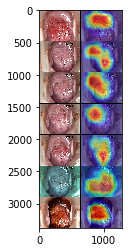

2


Using cache found in /root/.cache/torch/hub/pytorch_vision_master
Using cache found in /root/.cache/torch/hub/pytorch_vision_master
Using cache found in /root/.cache/torch/hub/pytorch_vision_master


2
torch.Size([3, 3376, 1286])


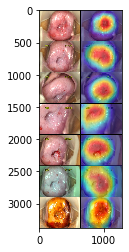

2


Using cache found in /root/.cache/torch/hub/pytorch_vision_master
Using cache found in /root/.cache/torch/hub/pytorch_vision_master
Using cache found in /root/.cache/torch/hub/pytorch_vision_master


0
torch.Size([3, 3376, 1286])


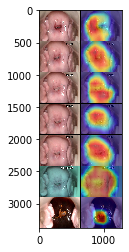

In [0]:
def grad_cam_plus_plus_visualize(index):
  normed_torch_imgs, y_real = get_images(index)
  masks, y_pred = extract_gradients_and_compute_mask(normed_torch_imgs)
  visualize_masked_imgs(masks, dataset_test_raw[index][0], 'out_{}_{}'.format(index, y_real == y_pred))

for i in range(3):
  grad_cam_plus_plus_visualize(i)